In [1]:
import os
import random
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler
import itertools
#from textblob import TextBlob
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

Path to directories where data is stored. Set home = 1 for WFH, 0 otherwise.

In [2]:
number_groups = int(input("Please specify analysis type.\nFor Act v Ctr, enter 2.\nFor EW\EWRE\CTR enter 3.\n"))

In [3]:
home = 1
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

utils

In [4]:
def run_gee(in_df,group_name,formula,cov_structure, resp_family):
    """ 
    Run statsmodels GEE.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe
    group_name: str
        column to group by
    formula:    str
        patsy formula
    cov_structure:  sm covariance structure
        covariance structure (e.g. sm.cov_struct.Independence())
    resp_family:    sm family (e.g. sm.families.Tweedie())
        mean response structure distribution

    Returns
    -------

    """
    model = smf.gee(formula,group_name, in_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
    qic_df = get_qic_table(in_df,formula,group_name,resp_family)
    
    return model, qic_df
    
def scale_scores(in_df, col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:    scaler to use

    Returns
    -------
    Nothing. Df is mutable, so function will change og df.

    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))



# extract numbers from strings
def find_number(text):
    """ 
    Extract numbers from strings

    Parameters
    ----------
    text: str
        input string to operate on
    
    Returns
    -------
    Numerical input string content as string.

    """ 
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

def get_diaries(directory,filenames,colnames):
    """
    Extract written statements from diary files.

    Parameters
    ----------
    directory:   str
        path to input directory
    filenames:  list
        list of input filenames to operate on
    colnames:   str
        columns to read in from diary files
    """
    pnums = []
    writing = []
    days = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2],usecols = colnames)
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        diary_df['day'] = i+1
        pnums.append(diary_df.iloc[:,1])
        writing.append(diary_df.iloc[:,2])
        days.append(diary_df.iloc[:,3])
    return pnums,days,writing

def set_initial_vals(in_df,col_list):
    """ 
    Set values for all assessment time points to session 1 value.

    Parameters
    ----------
    in_df:  pandas DataFrame
        dataframe to operate on
    col_list:   list
        list of columns to operate on

    Returns
    -------
    
    
    """
    sub_ids = in_df.id.unique()
    for pnum in (sub_ids):
        for col in col_list:
            initial_val = in_df.loc[(in_df.id==pnum)&(in_df.order==1),col].iloc[0]
            in_df.loc[(in_df.id==pnum)&(in_df.order.isin([2,3,4])), col] = initial_val
    
    return in_df

    
def demographics_check(in_df, num_subs):
    """ 
    Basic demographics check.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe to operate on
    num_subs:   int
        number of subjects
    
    Returns
    -------
        DataFrame of %age of sample in demographic categories.
    """
    demographics_df = in_df.filter(like = 'Selected Choice', axis = 1)
    sex = demographics_df.filter(like = 'your sex',axis = 1).value_counts()/num_subs
    ethnicity = demographics_df.filter(like = 'your ethnic group',axis = 1).value_counts()/num_subs
    education = demographics_df.filter(like = 'education',axis = 1).value_counts()/num_subs
    working = demographics_df.filter(like = 'working',axis = 1).value_counts()/num_subs

    op_df = pd.DataFrame({'sex': sex, 'ethnicity':ethnicity,'education':education,'working':working})
    return (op_df)*100
    
class Data_Explorer:
    """
    Class to use for data exploration 
    """
    def __init__(self, response_var, groups = None):
        if not groups:
            self.groups = 3
        else:
            self.groups = groups
        self.response_name = response_var
    
    def nan_ids(self,in_df):
        self.response_vals = in_df[self.response_name]
        self.nan_ids = in_df.loc[in_df[self.response_name].isna(),'id'].values
    
    def zero_ids(self, in_df):
        self.zero_ids = in_df.loc[in_df[self.response_name]==0, 'id'].unique()
        self.zero_groups = in_df.loc[in_df.id.isin(self.zero_ids),'Group'].value_counts()
    
    
    def visualize_dist(self, distribution = None):
        if not distribution:
            self.distribution = 'normal'
        else:
            self.distribution = distribution


        if self.distribution == 'normal':
            fig = sm.qqplot(self.response_vals,line = 'q')
            fig.show()
        else:
            fig = sm.qqplot(self.response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()
    
    def draw_kdeplot(self,in_df,names,colors):
        for i,session in enumerate(in_df.order.unique()):
            fig = sns.kdeplot(in_df.loc[in_df.order == session, self.response_name],color = colors[i] )
        plt.legend(names)
    
    def draw_mean_trajectories(self,in_df):
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
        x=in_df.time,
        trace=in_df.Group,
        response=in_df[self.response_name],
        colors=["red", "blue","black"],
        markers=["D", "^",'x'],
        ms=10,
        ax=ax,
        )
               
def get_qic_table(data_df, formula, group, family_name):
    """ 
    Compare models with different covariance structures, based on QIC.

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    formula:    str
        statsmodels GEE formula (patsy)
    group:  str
        column to group by
    family_name:    str
        mean response structure name
    
    Returns
    -------
        Pandas DataFrame containing qic values for each model.
    """
    model_covi = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Independence(), family = family_name,missing = 'drop').fit()
    model_covx = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Exchangeable(), family = family_name,missing = 'drop').fit()
    model_covar = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Autoregressive(), family = family_name,missing = 'drop').fit()
    out_df = pd.DataFrame({'dependency type': ['Independence','Exchangeable','Autoregressive'], 'QIC': [model_covi.qic()[0], model_covx.qic()[0],model_covar.qic()[0]], 'QICu': [model_covi.qic()[1], model_covx.qic()[1],model_covar.qic()[1]]})
    return out_df

# simulate some data for the prediction (mean +/- 1 std)
def simulate_to_predict(dat_vals):
    dat_sim = []
    mu = dat_vals.mean()
    std = dat_vals.std()
    for i in range(0,len(dat_vals)):
        value = random.gauss(mu,std)
        if value>mu+std:
            value == mu+std
        elif value<mu-std:
            value == mu-std
        dat_sim.append(value)
    return dat_sim

def model_checks(data_df, columns_to_use, y_to_use,GEE_res):
    """
    Model diagnostics

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    columns_to_use: str
        names of columns containing predictors to be used in the analysis
    y_to_use:   str
        names of outcome column
    GEE_res:    
        GEE model results

    -------
    """
    gee_res_df = data_df.loc[:,columns_to_use]
    drop_inds = gee_res_df.loc[gee_res_df[y_to_use].isna(),:].index.values
    gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)
    gee_res_df['resid_dev'] = GEE_res.resid_deviance
    gee_res_df['fitted'] = GEE_res.fittedvalues
    a = GEE_res.resid_deviance
    a.sort()
    fig = plt.figure()
    res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
    plt.show()
    # plotting fitted agains residuals
    g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Predicted score", "Deviance residuals"))#.set(xlim=(42, 55)))
    g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14)))

# function to calculate cluster cook statisticts. Doesn't work as intended though so not used. Couldn't find the bug???
def cooks_d(data_df, formula_to_use, group_to_use, cov_structure, resp_family, orig_GEE_res,num_params):
    """ 
    Calculate cluster cook statistics.

    Params
    ------

    Returns
    -------
    
    """
    cooks_dist = []
    all_ids = []
    for i,pnum in enumerate(data_df.id.unique()):
        # eliminate id from dataframe
        red_df = data_df.drop(labels = data_df.loc[data_df.id == pnum].index.values,axis = 0)
        # fit model
        model_red = smf.gee(formula_to_use,group_to_use, red_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
        # get coefficients
        #drops = list(orig_GEE_res.fittedvalues.index.values)
        #droplabels = np.array([f for f in drops if f not in list(model_red.fittedvalues.index.values)])
        diff_full = abs(orig_GEE_res.fittedvalues-model_red.fittedvalues)
        cooks_d = np.sum(np.square(diff_full))/(num_params*np.mean(np.square(orig_GEE_res.resid_deviance)))
        cooks_dist.append(cooks_d)
        all_ids.append(pnum)
    cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})
    return cooks_distance_df

def kruskal_dunns_func(in_df, time_col, group_name, time_point,outcome):
    """
    Check for significant differences using
    Kruskal Wallis test and Dunn's post-hoc

    Paramters
    ---------
    in_df:  pandas Dataframe
        Input dataframe
    time_col:   str
        Name of time point column in in_df
    group_name: str
        Groups to compare
    time_point: int
        time point for which to compare data
    outcome:    str
        outcome to compare on
    """
    data = []
    for group in group_name:
        data.append(in_df.loc[(in_df.Group==group)&(in_df[time_col]==time_point),outcome].dropna().values)
    print('Outcome:{},\nstats: {}\n'.format(outcome, stats.kruskal(data[0],data[1],data[2])))
    print('Posthoc:\n1 = {}, 2 = {}, 3 = {}\n {}\n'.format(group_name[0],group_name[1],
            group_name[2], sp.posthoc_dunn(data, p_adjust = 'bonferroni')))

In [22]:
class Data_Analyser:
    """
    Class to use for data analysis (duh)
    """
    def __init__(self, response_var, groups = None):
        self.response_name = response_var
        if not groups:
            self.groups = ['EW','EWRE','CTR']
            self.formula = ''.join(
                            [self.response_name,
                            " ~ C(time) * C(Group,Treatment('CTR'))"]
                            )
        else:
            self.groups = groups
            self.formula = ''.join(
                            [self.response_name,
                            " ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))"]
                            )
        self.num_groups = len(self.groups)
        
    def kruskal_dunns_func(self, in_df, time_col, group_col, time_point,outcome):
        """
        Check for significant differences using
        Kruskal Wallis test and Dunn's post-hoc

        Paramters
        ---------
        in_df:  pandas Dataframe
            Input dataframe
        time_col:   str
            Name of time point column in in_df
        group_col: str
            Name of group column in in_df
        group_name: str
            Groups to compare
        time_point: int
            time point for which to compare data
        outcome:    str
            outcome to compare on
        """
        data = []
        for group in self.groups:
            data.append(in_df.loc[(in_df[group_col]==group)&(in_df[time_col]==time_point),outcome].dropna().values)
        if self.num_groups == 3:
            with open(''.join(["kruskal_wallis_res",self.response_name,".txt"]),"w") as f:
                f.write('Outcome:{},\nstats: {}\n'.format(outcome, stats.kruskal(data[0],data[1],data[2])))
                f.write('Posthoc:\n1 = {}, 2 = {}, 3 = {}\n {}\n'.format(self.groups[0],self.groups[1],
                        self.groups[2], sp.posthoc_dunn(data, p_adjust = 'bonferroni')))
        else:
            with open(''.join(["kruskal_wallis_res",self.response_name, ".txt"]),"w") as f:
                f.write('Outcome:{},\nstats: {}\n'.format(outcome, stats.kruskal(data[0],data[1])))
                f.write('Posthoc:\n1 = {}, 2 = {}, {}\n'.format(self.groups[0],self.groups[1],
                        sp.posthoc_dunn(data, p_adjust = 'bonferroni')))

    def run_gee(self, in_df, group_name, cov_structure, resp_family, **moderators):
        """ 
        Run statsmodels GEE.

        Parameters
        ----------
        in_df:  pandas DataFrame
            input dataframe
        group_name: str
            column to group by
        formula:    str
            patsy formula
        cov_structure:  sm covariance structure
            covariance structure (e.g. sm.cov_struct.Independence())
        resp_family:    sm family (e.g. sm.families.Tweedie())
            mean response structure distribution

        Returns
        -------

        """
        if moderators:
            for key in moderators.keys():
                print(moderators[key])
                formula = ''.join([self.formula,
                                 moderators[key]])
        else:
            formula = self.formula
        try:
            self.model = smf.gee(formula,group_name, in_df,
                            cov_struct = cov_structure, family = resp_family,
                            missing = 'drop').fit()
        except ValueError:
            warnings.warn(
                        "Covariance structure changed to Independence.",
                            category = UserWarning)
            self.model = smf.gee(formula,group_name, in_df,
                            cov_struct = sm.cov_struct.Independence(),
                            family = resp_family,
                            missing = 'drop').fit()
        return self.model
    
    def get_qic_table(self, in_df, group, family_name,**moderators):
        """ 
        Compare models with different covariance structures, based on QIC.

        Parameters
        ----------
        data_df:    pandas DataFrame
            input dataframe
        formula:    str
            statsmodels GEE formula (patsy)
        group:  str
            column to group by
        family_name:    str
            mean response structure name
    
        Returns
        -------
            Pandas DataFrame containing qic values for each model.
        """
        if moderators:
            for key in moderators.keys():
                print(moderators[key])
                formula = ''.join([self.formula,
                                 moderators[key]])
        else:
            formula = self.formula
        
        model_covi = smf.gee(formula,group, in_df, cov_struct = sm.cov_struct.Independence(), family = family_name,missing = 'drop').fit()
        model_covx = smf.gee(formula,group, in_df, cov_struct = sm.cov_struct.Exchangeable(), family = family_name,missing = 'drop').fit()
        try:
            model_covar = smf.gee(formula,group, in_df, cov_struct = sm.cov_struct.Autoregressive(), family = family_name,missing = 'drop').fit()
            covar_qic = model_covar.qic()
        except ValueError:
            warnings.warn(
                        "Autoregressive can't find the right bracket.",
                        category = UserWarning
                        )
            covar_qic = [np.nan, np.nan]
        self.qic = pd.DataFrame({'dependency type': ['Independence','Exchangeable','Autoregressive'],
                     'QIC': [model_covi.qic()[0], model_covx.qic()[0],covar_qic[0]],
                     'QICu': [model_covi.qic()[1], model_covx.qic()[1],covar_qic[1]]})
        return self.qic

    def model_checks(self, in_df, group_col, columns_to_use):
        """
        Model diagnostics

        Parameters
        ----------
        data_df:    pandas DataFrame
            input dataframe
        group_col:  str
            name of group column in in_df
        columns_to_use: str
            names of columns containing predictors to be used in the analysis
        y_to_use:   str
            names of outcome column
        GEE_res:    
            GEE model results
        -------
        """
        gee_res_df = in_df.loc[:,columns_to_use]
        drop_inds = gee_res_df.loc[gee_res_df[self.response_name].isna(),:].index.values
        gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)
        gee_res_df['resid_dev'] = self.model.resid_deviance
        gee_res_df['fitted'] = self.model.fittedvalues
        a = self.model.resid_deviance
        a.sort()
        fig = plt.figure()
        res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
        plt.show()
        # plotting fitted agains residuals
        g = sns.lmplot(x = "fitted", y = "resid_dev", hue = group_col, data = gee_res_df)
        g = (g.set_axis_labels("Predicted score", "Deviance residuals"))
        g = sns.lmplot(x = "time", y = "resid_dev", hue = group_col, data = gee_res_df)
        g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14)))
        #g.save(os.path.join(output_dir,''.join([self.response_name,strip(),'.png'])))

Load the qualtrics data and add columns for time in weeks and whether or not the same event was reported in the ADNM-20. The latter is done by checking the sequence matcher and spacy based scores against a pre-set threshold.

In [6]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
# column to denote whether or not they reported the same stressful events for the ADNM-20 at each time point
all_dat_df['same_event'] = 0
# if spacy version suggests >0.8 similarity, set to 1 (inspection showed that this seems to be a reasonable cut-off.)
all_dat_df.loc[all_dat_df.most_stressful_similarity2>0.8,'same_event'] = 1
all_dat_df.loc[(all_dat_df.most_stressful_similarity>0.2)&(all_dat_df.most_stressful_similarity2<0.8),'same_event'] = 1 # also set to 1 if spacy is below the cut-off, but SequenceMatcher is higher than 0.2 (based on visual inspection)
all_dat_df.loc[(all_dat_df.order==1),'same_event']=np.nan

all_dat_df['time'] = all_dat_df.order
for i,ord_time in enumerate([0,2,4,12]):
    all_dat_df.loc[all_dat_df.order==i+1,'time'] = ord_time

# combine the two active groups into a single group.
all_dat_df['Group_act_v_ctr'] = all_dat_df.Group.replace('EWRE','EW')
scale_scores(all_dat_df,['ERQ_reapp','ERQ_sup','RRS_total','ADNM_burden_total'],StandardScaler())

if number_groups == 2:
    group_col = 'Group_act_v_ctr'
else:
    group_col = 'Group'

# add a column indicating whether they reported the same or different events
all_dat_df.loc[(all_dat_df.order == 1),'same_event'] = 1
all_ids = []
for pnum in all_dat_df.id.unique():
    if all_dat_df.loc[all_dat_df['id']==pnum,'same_event'].sum()==4:
        all_ids.append(pnum)
    else:
        continue
all_dat_df['all_same'] = 0
all_dat_df.loc[all_dat_df.id.isin(all_ids),'all_same'] = 1

In [7]:
# set ERQ and RRS values to session 1 vals.
all_dat_df = set_initial_vals(all_dat_df, ['ERQ_reapp','ERQ_sup','RRS_total'])
# check demographics.
num_subs = len(all_dat_df.id.unique())
demographics_sum = demographics_check(all_dat_df, num_subs)

We've now got to find participant ages. These are in the screening data file, which does not have participant numbers, only screening ids. We therefore have to match the screening ids to the participant numbers via the randomisation file.

In [ ]:
screening_df = pd.read_csv(os.path.join(rand_dir, 'screening_data.csv'),skiprows = [0,2],usecols = ['Please enter the last four digits of your phone number','Please enter your age.'])
rand_df = pd.read_csv(os.path.join(rand_dir,'randomisation.csv'))
rand_df.loc[:,'Screening Id'] = rand_df['Screening Id'].apply(find_number).astype('int')
screening_df = screening_df.loc[screening_df['Please enter the last four digits of your phone number'].isin(rand_df['Screening Id']),:]
screening_df['id'] = rand_df.loc[rand_df['Screening Id'].isin(screening_df['Please enter the last four digits of your phone number']),'Participant number'].apply(find_number).astype('int')
print("The mean age was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].mean())
print("Std was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].std())
print("The range was: ", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].min(), screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].max())

Data exploration


Displaying results...

Outcome: ADNM_burden_total
There are 11 zeros in response variable ADNM_burden_total.
There are 4 NaNs in response variable ADNM_burden_total.

Displaying results...

Outcome: dass_depression
There are 17 zeros in response variable dass_depression.
There are 0 NaNs in response variable dass_depression.

Displaying results...

Outcome: dass_anxiety
There are 39 zeros in response variable dass_anxiety.
There are 0 NaNs in response variable dass_anxiety.

Displaying results...

Outcome: dass_stress
There are 16 zeros in response variable dass_stress.
There are 0 NaNs in response variable dass_stress.


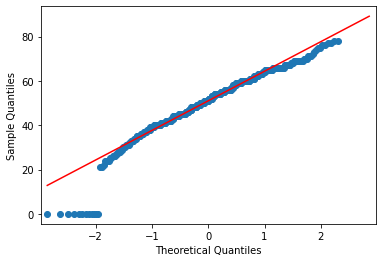

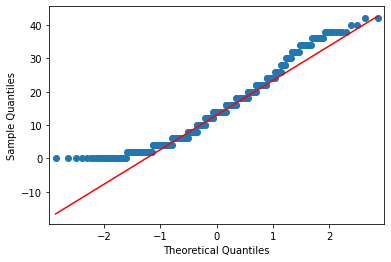

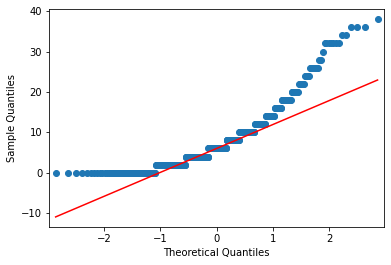

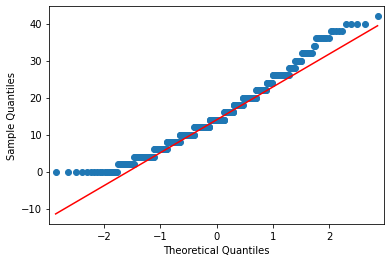

In [10]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    print('\nDisplaying results...\n')
    dt = Data_Explorer(outcome)
    dt.nan_ids(all_dat_df)
    dt.zero_ids(all_dat_df)
    print('Outcome: {}'.format(dt.response_name))
    print(f'There are {len(dt.zero_ids)} zeros in response variable {dt.response_name}.')
    print(f'There are {len(dt.nan_ids)} NaNs in response variable {dt.response_name}.')

    dt.visualize_dist()

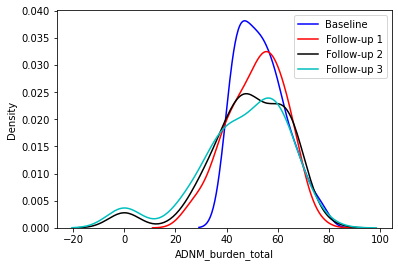

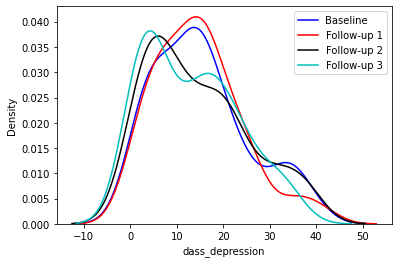

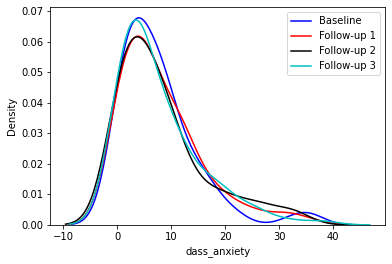

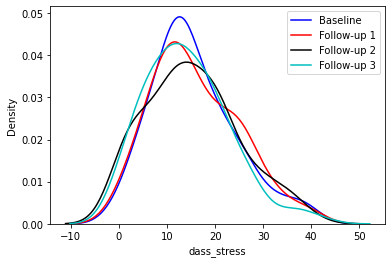

In [11]:
for i,outcome in enumerate(['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']):
    dt = Data_Explorer(outcome)
    colors = ['b','r','k','c']
    names = ['Baseline','Follow-up 1', 'Follow-up 2','Follow-up 3']
    plt.figure(i)
    dt.draw_kdeplot(all_dat_df,names, colors)

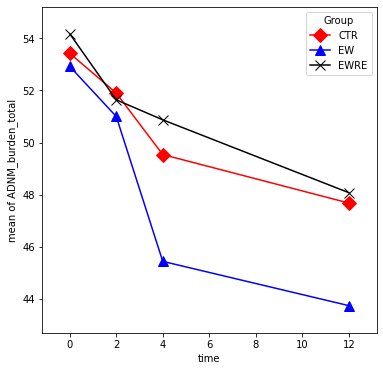

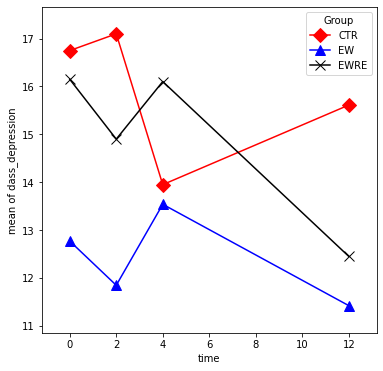

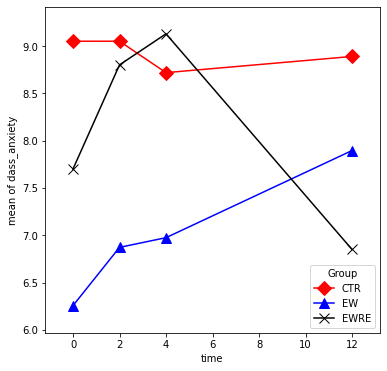

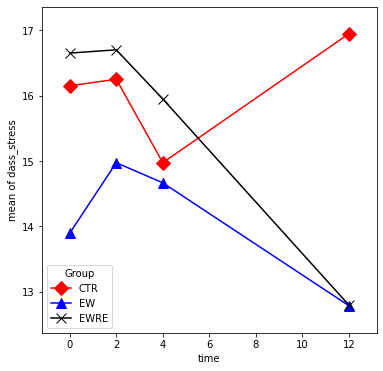

In [12]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    dt = Data_Explorer(outcome)
    dt.draw_mean_trajectories(all_dat_df)

Analysis

Group names: ['EW', 'CTR']

Modelling response: ADNM_burden_total

Formula is: ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))





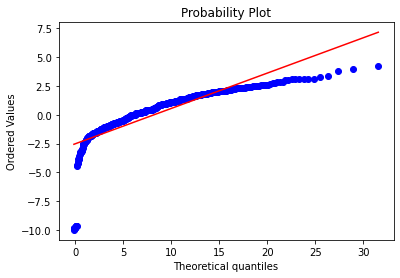

*ERQ_reapp_scaled
*ERQ_reapp_scaled


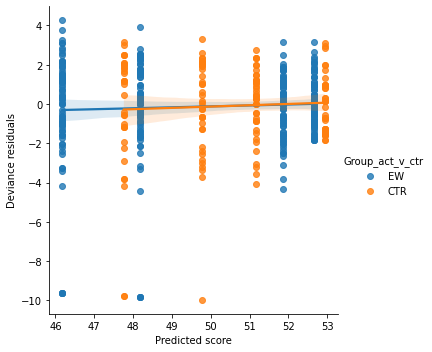

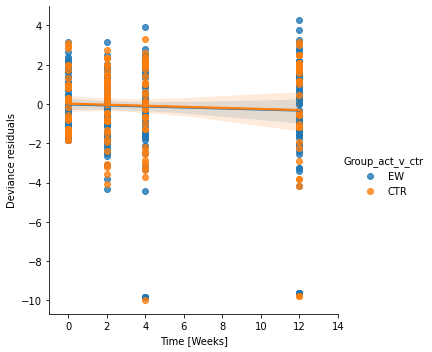

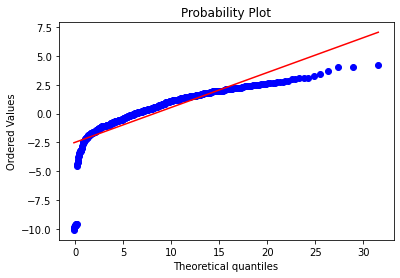

*ERQ_sup_scaled
*ERQ_sup_scaled


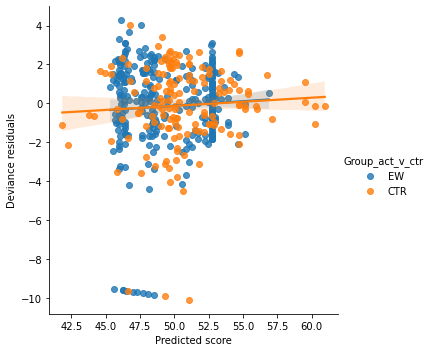

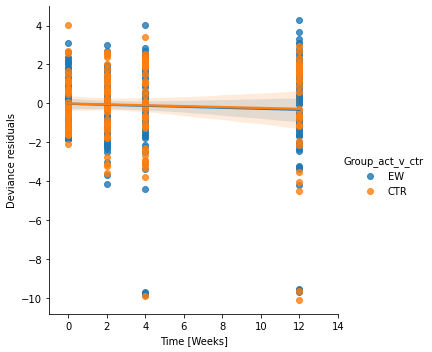

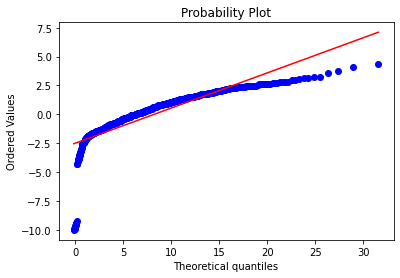

*RRS_total_scaled
*RRS_total_scaled


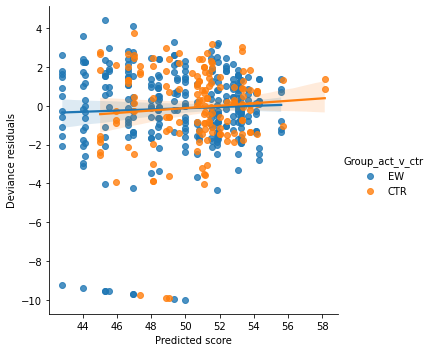

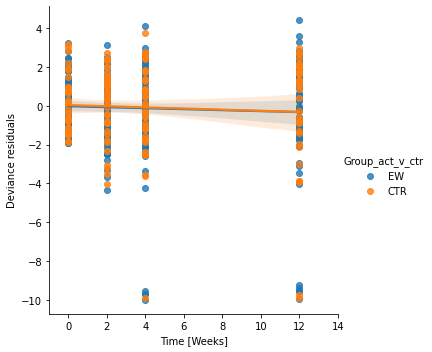

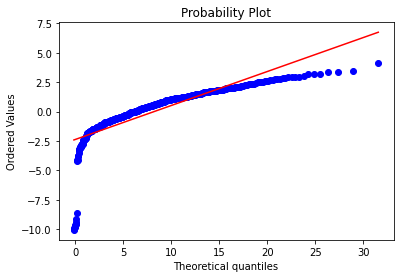

Group names: ['EW', 'CTR']

Modelling response: dass_anxiety

Formula is: dass_anxiety ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))





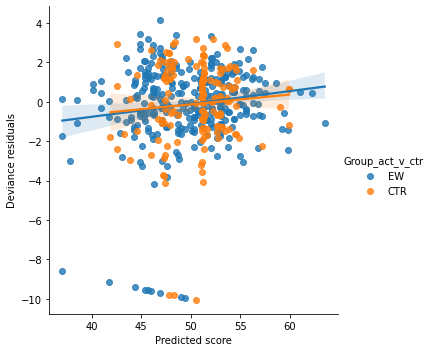

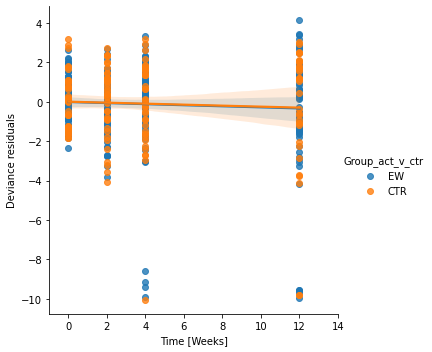

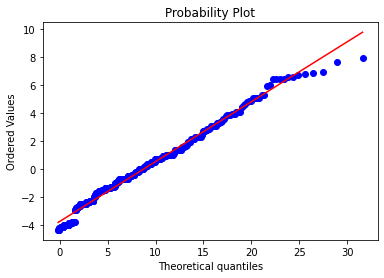

*ERQ_reapp_scaled
*ERQ_reapp_scaled


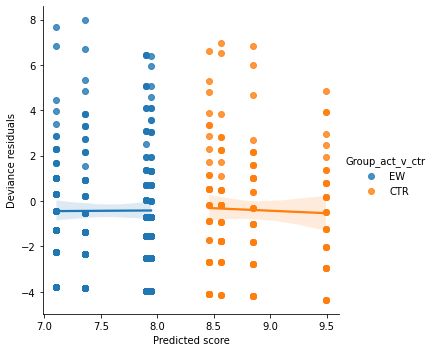

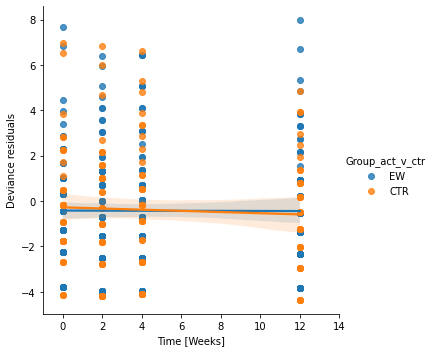

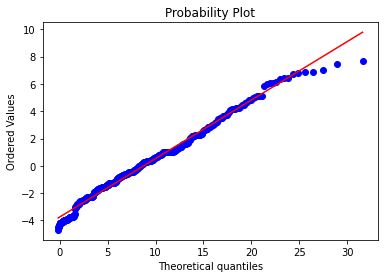

*ERQ_sup_scaled
*ERQ_sup_scaled


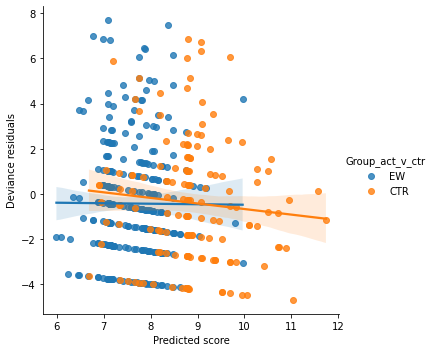

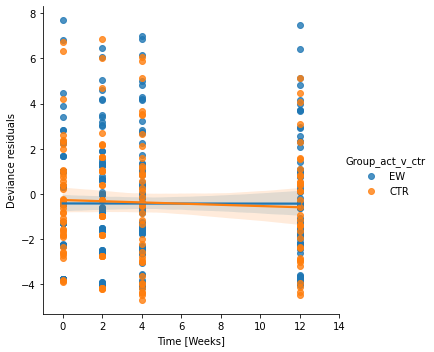

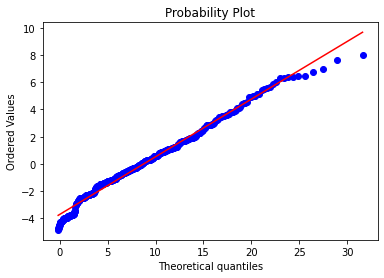

*RRS_total_scaled
*RRS_total_scaled


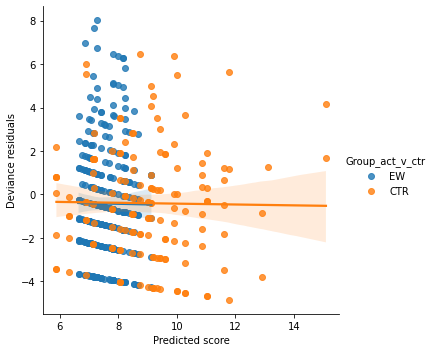

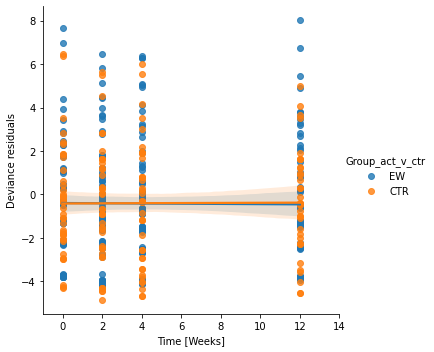

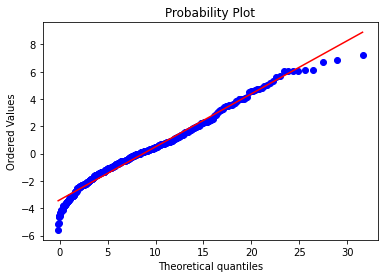

Group names: ['EW', 'CTR']

Modelling response: dass_depression

Formula is: dass_depression ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))





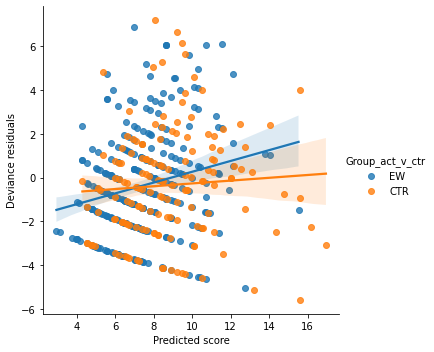

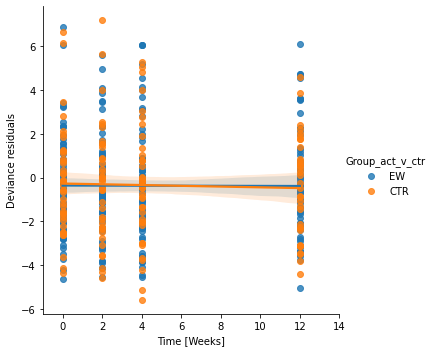

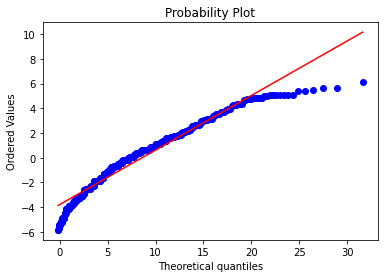

*ERQ_reapp_scaled
*ERQ_reapp_scaled


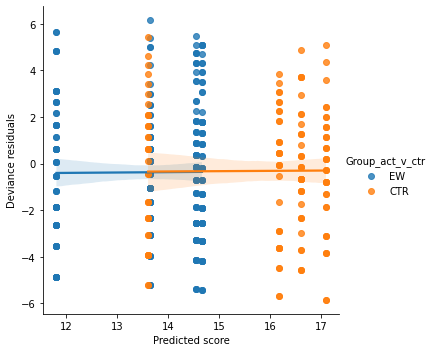

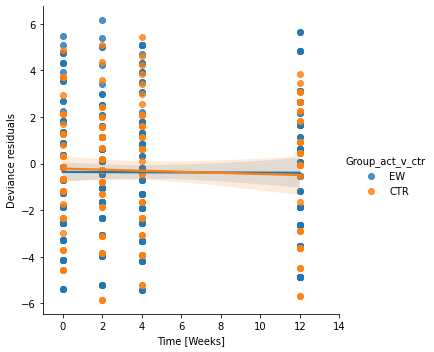

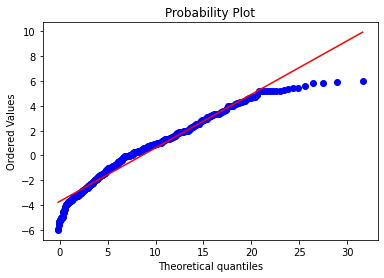

*ERQ_sup_scaled
*ERQ_sup_scaled


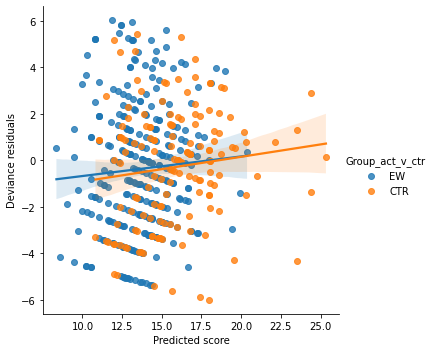

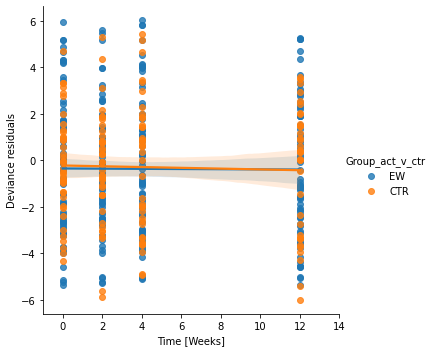

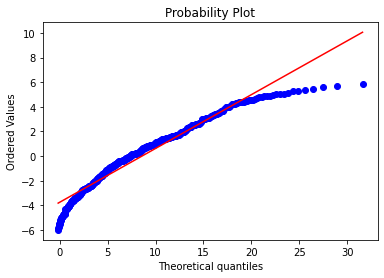

*RRS_total_scaled
*RRS_total_scaled


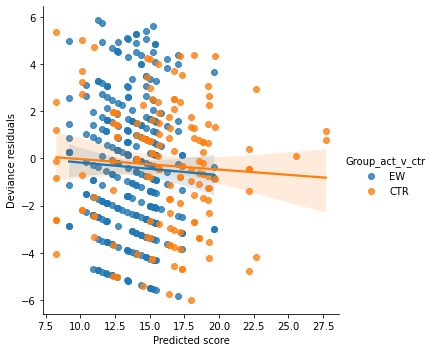

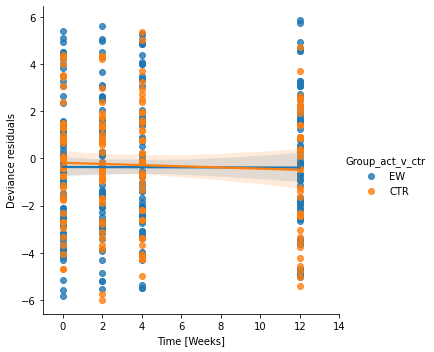

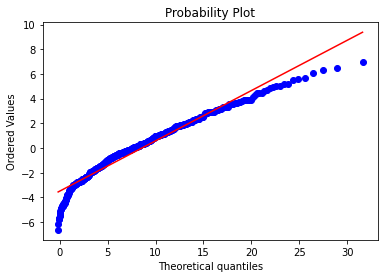

Group names: ['EW', 'CTR']

Modelling response: dass_stress

Formula is: dass_stress ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))





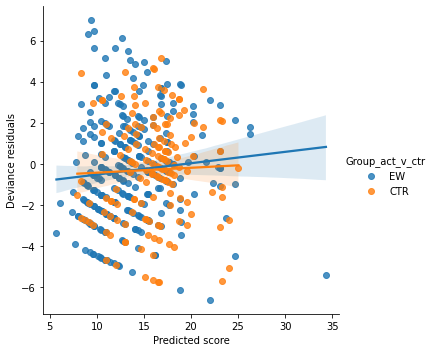

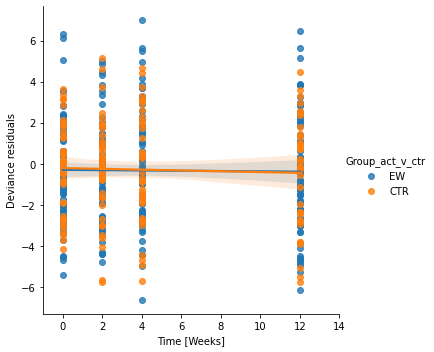

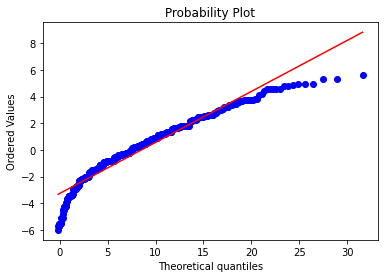

*ERQ_reapp_scaled
*ERQ_reapp_scaled


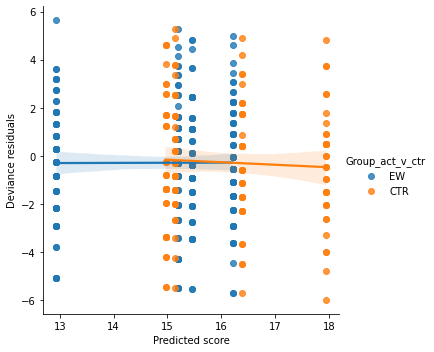

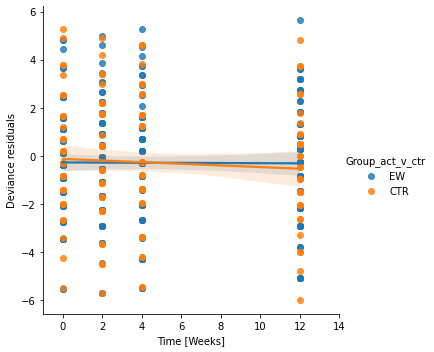

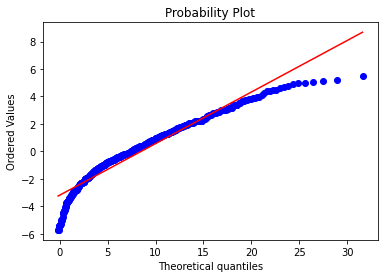

*ERQ_sup_scaled
*ERQ_sup_scaled


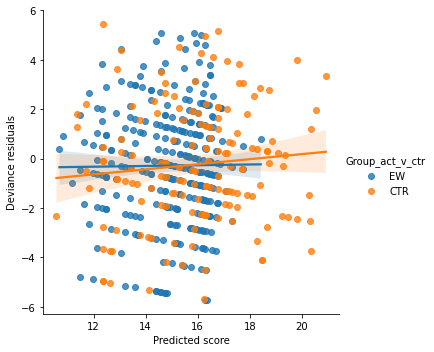

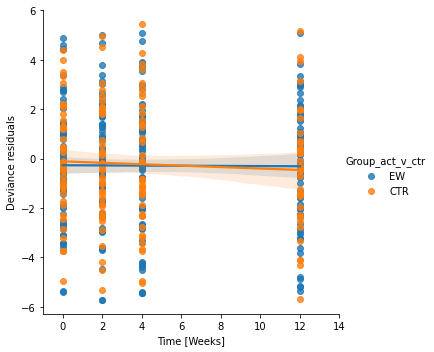

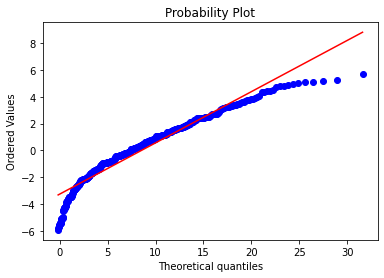

*RRS_total_scaled
*RRS_total_scaled


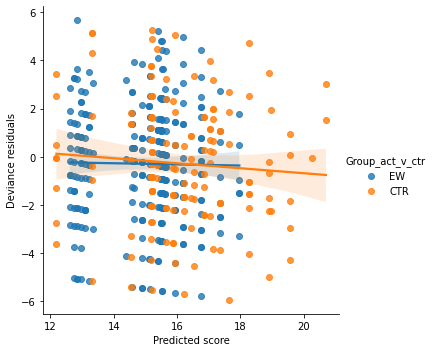

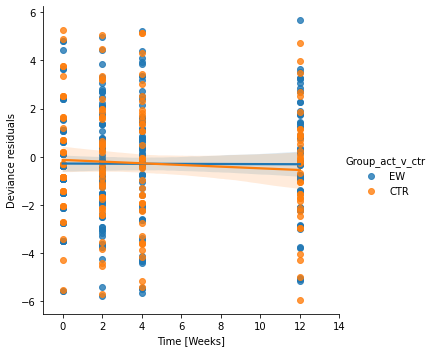

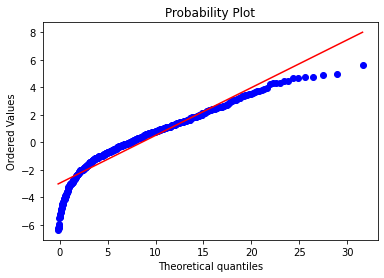

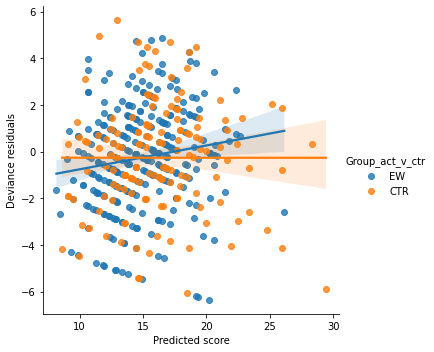

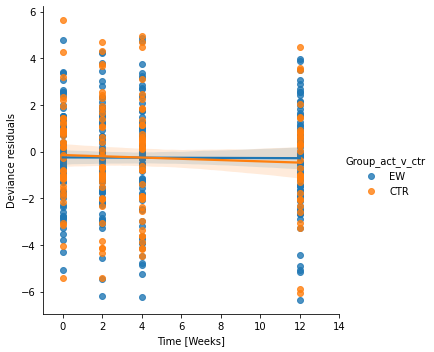

In [23]:
if number_groups == 3:
    group_col = 'Group'    
else:
    group_col = 'Group_act_v_ctr'

group_names = [f for f in all_dat_df[group_col].unique()]
outcomes = ['ADNM_burden_total','dass_anxiety','dass_depression','dass_stress']
moderators = ['','*ERQ_reapp_scaled','*ERQ_sup_scaled','*RRS_total_scaled']

for resp in outcomes:
    da = Data_Analyser(resp, group_names)
    print(f"Group names: {da.groups}\n")
    print(f"Modelling response: {da.response_name}\n")
    print(f"Formula is: {da.formula}\n")
    da.kruskal_dunns_func(all_dat_df,'time',group_col,0, resp)
    for mod in moderators:
        model = da.run_gee(all_dat_df,"id", sm.cov_struct.Autoregressive(),
                        sm.families.Tweedie(),moderators = mod)
        qic_df = da.get_qic_table(all_dat_df,'id',sm.families.Tweedie(), moderators = mod)
        with open(''.join(["model_results_",da.response_name,".txt"]), "a") as f:
            f.write(f"{da.response_name}:\n{model.summary()}\n")
            f.write(f"{da.response_name}:\n{da.qic}\n")
        da.model_checks(all_dat_df,group_col, [resp,'id','time',group_col])